# Deep note - Introduction à la quantization

Projet Intelligence Artificielle - Groupe 8 - EFREI

Chloé DESRUE - Marie SAYAG - Manon WIECLAW

In [1]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
import os

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


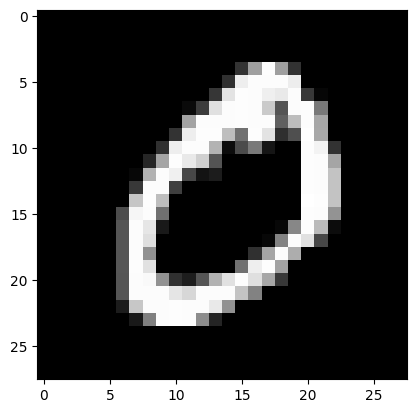

In [3]:
pyplot.imshow(train_X[1], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation,Flatten
#import tensorflow_model_optimization as tfmot

In [5]:
print(train_X.shape)

(60000, 28, 28)


In [6]:
print(test_X.shape)

(10000, 28, 28)


In [7]:
#import numpy as np
#Reshape et normalisation minMaxScalling

train_X = train_X.reshape(60000, 28, 28, 1)/255  #minmax scalling
train_X.shape

test_X = test_X.reshape(-1, 28, 28, 1)/255  #minmax scalling
test_X.shape


(10000, 28, 28, 1)

In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation='relu')) #32 neurone
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(units = 150, activation='relu',input_shape =[28**2]))
model.add(Dense(units=10, activation='softmax'))

model.compile (loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) #ou sgd pour optimizer




In [9]:
model.fit(train_X, train_y, epochs=10, validation_data = [test_X, test_y])

Epoch 1/10
1875/1875 [==============================] - 250s 130ms/step - loss: 0.1114 - accuracy: 0.9657 - val_loss: 0.0430 - val_accuracy: 0.9849
Epoch 2/10
1875/1875 [==============================] - 215s 115ms/step - loss: 0.0363 - accuracy: 0.9890 - val_loss: 0.0393 - val_accuracy: 0.9859
Epoch 3/10
1875/1875 [==============================] - 213s 113ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0354 - val_accuracy: 0.9885
Epoch 4/10
1875/1875 [==============================] - 215s 115ms/step - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.0356 - val_accuracy: 0.9896
Epoch 5/10
1875/1875 [==============================] - 206s 110ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0396 - val_accuracy: 0.9888
Epoch 6/10
1875/1875 [==============================] - 201s 107ms/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 0.0461 - val_accuracy: 0.9890
Epoch 7/10
1875/1875 [==============================] - 211s 112ms/step - loss: 0.0074 - accuracy: 0.9974 - val_

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 150)               1382550   
                                                                 
 dense_1 (Dense)             (None, 10)                1510      
                                                        

Accuracy du modèle non quantifié : 

In [11]:
score = model.evaluate(test_X, test_y, verbose=0)

print('Test accuracy:', score[1])

Test accuracy: 0.9896000027656555


In [12]:
import joblib
joblib.dump(model, 'classification_modele.joblib') 

['classification_modele.joblib']

In [42]:
size = os.path.getsize("classification_modele.joblib")
print (size, 'octets')

16868450 octets


# **Quantization post training**

In [13]:
#import joblib
#model = joblib.load('/content/drive/MyDrive/IA/classification_modele.joblib')

import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Taille du fichier généré model.tflite : 5.6 Mo

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_quant_model = converter.convert()

#save the model
with open('model_optimize.tflite', 'wb') as f:
  f.write(tf_quant_model)

In [38]:
size_post = os.path.getsize("model_optimize.tflite")
print (size_post, 'octet')

1408624 octet


La taille du fichier généré est plus petite : 1,4 Mo
Optimize.DEFAULT utilise la quantification de plage dynamique

# **Quantization aware training**

In [45]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot


qat_model = tfmot.quantization.keras.quantize_model(model)



^C


In [46]:
qat_model.compile (loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy']) 
qat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (QuantizeL  (None, 28, 28, 1)        3         
 ayer)                                                           
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 26, 26, 32)       387       
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 24, 24, 64)       18627     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d (Quanti  (None, 12, 12, 64)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_flatten (QuantizeWrap  (None, 9216)             1

Réentraîner votre modèle sur un sous ensemble des modèles sur une ou deux epochs et afficher la performance sur le train et test

In [47]:
train_X.max()

1.0

In [48]:
X_train_min = train_X[0:1000]
Y_train_min = train_y[0:1000]
print(X_train_min.shape)
print(train_X.shape)


(1000, 28, 28, 1)
(60000, 28, 28, 1)


In [50]:
qat_model.fit(X_train_min, Y_train_min, epochs=2, validation_data = [test_X, test_y])

Epoch 1/2
32/32 [==============================] - 14s 454ms/step - loss: 0.0028 - accuracy: 0.9980 - val_loss: 0.0434 - val_accuracy: 0.9885
Epoch 2/2
32/32 [==============================] - 14s 439ms/step - loss: 4.0884e-04 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9888


## Conversion du modèle avec TFLite

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_qat_model = converter.convert()

#save the model
with open('QAT.tflite', 'wb') as f:
  f.write(tflite_qat_model)

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [52]:
size_QAT = os.path.getsize("QAT.tflite")
print (size_QAT, 'octet')

1410672 octet


Taille du modèle obtenu : 1.4 Mo

# Comparer les performances des trois modèles (taille et accuracy)

Calcul de l'accuracy pour le post training : 

In [28]:
interpreter = tf.lite.Interpreter("model_optimize.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()

output_details = interpreter.get_output_details()

input_details

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([ 1, 28, 28,  1], dtype=int32),
  'shape_signature': array([-1, 28, 28,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [36]:
acc = 0

for i in range (len(test_y)):
  inp = test_X[i].reshape(1, 28, 28, 1).astype("float32")
  interpreter.set_tensor(input_details[0]["index"], inp)

  interpreter.invoke()

  prediction = interpreter.get_tensor(output_details[0]["index"])
  classe = np.argmax(prediction) #plus grande probabilité d'appartenir à cette classe


  if (classe == test_y[i]):
    acc += 1
    

accuracy_post = acc / i

print(accuracy_post)   

0.9896989698969897


Accuracy des trois modèles ainsi que leurs tailles : 

In [44]:
baseline_model_accuracy = model.evaluate(
    test_X, test_y, verbose=0)

q_aware_model_accuracy = qat_model.evaluate(
   test_X, test_y, verbose=0)

print('\nBaseline test accuracy:', baseline_model_accuracy[1], 'and size :',size ,'octets')

print('\nAware training accuracy:', q_aware_model_accuracy[1], 'and size :',size_QAT, 'octets')

print('\nPost training accuracy:', accuracy_post, 'and size :', size_post, 'octets')


Baseline test accuracy: 0.9896000027656555 and size : 16868450 octets

Aware training accuracy: 0.9884999990463257 and size : 1410664 octets

Post training accuracy: 0.9896989698969897 and size : 1408624 octets


Convertir le modèle - tensorflow for microcontrollers

In [26]:
!xxd -i QAT.tflite > model_data.cc


In [27]:
!xxd -i QAT.tflite > model_data.h